In [1]:
# Set the matplotlib magic. This line is specific to ipython notebooks.
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# Import some useful module.
import time
from matplotlib import pyplot as plt
from IPython.display import HTML
import numpy as np
import math

# Import the system module.
import mag_lev

In [2]:
# Format Plots
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 150

# Change font
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Constants
These are computed based on the analysis from `model_exploration.ipynb`

In [152]:
MAX_VOLTAGE = 10.0                   # [V]
R = 2.41                             # Coil Resistance [ohms]
L = 0.015266817305695372             # Inductance [H]
c_I_to_V_h = 0.47996355000000007     # Computed scaling constant between electromagnet current and hall voltage
# Lumped parameter constants for V_h to position
hall_params = [2.58897620e-05, 2.49441669e+00, 1.35761509e-02]

# Lumped paramter in electromagnet current to position model
#C1 = -0.0000034 # Hand-picked for now - used in bode plots
C1 = -0.0000025 # New adjusted constant
# For computing hall voltage contribution from magnet
C2 = 0.86 # Electromagnet voltage scaling
C3 = 0.39 # Current derivative scaling

# Linearization setpoints
m = 0.003  # Permanent magnet mass [kg]
I_bar = 1.5 # Note: magnet will be pre-charged to this value
y_bar = 0.03 # Note: this is the point where we will try to control around
V_e_bar = I_bar * R # Theoretical voltage needed to create I_bar

## Functions
These functions use the above constants and are based on relationships discovered in the file `model_exploration.ipynb`

In [153]:
# Modeling Functions
def PWMtoVolts(PWM):
    """Convert from PWM command to electromagnet voltage"""
    return PWM/255 * MAX_VOLTAGE

def voltsToPWM(V_e):
    """Convert from electromagnet voltage to PWM command"""
    return V_e/MAX_VOLTAGE * 225

def currentToHallVoltage(I):
    return c_I_to_V_h * I

def computeSteadyStateCurrent(PWM):
    V_e = PWMtoVolts(PWM)
    I = V_e / R
    return I

def computeElectromagnetVoltage(I):
    """Compute theoretical voltage needed to create steady-state current"""
    V_e = I * R
    return V_e

def convertToDistance(V_h, I, dI):
    """Computes distance of permanent magnet from electromagnet based on
    input hall voltage by subtracting contribution from electromagnet """

    # Check for clipping
    if V_h > 4:
        y = 0.015
#         print("Warning: Clipping in hall voltage - check gains and that the magnet isn't too close")
        return y
    
    # Compute hall voltage contribution from electromagnet
    V_h_from_e = c_I_to_V_h * I
    
    # Compute hall voltage contribution from magnet
    V_h_from_m = V_h - C2*V_h_from_e + C3*dI
    
    # Convert from hall voltage to position
    y = voltToPos(V_h_from_m,  *hall_params)   

    # Cap y within range
    if np.iscomplex(y) or y > 0.1:
        y = 0.1
#         print("Warning: magnet has probably fallen")

    elif y < 0.015:
        # We can't accurately measure less than 1.5cm away anyways
        y = 0.015
#         print("Warning: magnet has moved too close to electromagnet")
        
    return y
        
def posToVolt(x, a, b, c):
    return a/((x + c)**3) + b

def voltToPos(x, a, b, c):
    return (a/(x - b))**(1/3) - c

def computePIDController(Kp, Ki, Kd, e, E, de):
    """Based on the current converted sensor reading, compute the next
    electromagnet voltage command to send to the plant"""

    # Compute new command
    V_e = e*Kp + E*Ki + de*Kd + V_e_bar # V_e_bar is added to counteract effect of disturbance (gravity)

    # Limit V_e to match physical constraints of the system
    if V_e < 0:
        V_e = 0
    elif V_e > 7: # Set 7V as the max voltage to use
        V_e = 7 
    return V_e

## Controller
This code runs the simulator, and uses our model to keep track of current over time to compute the current position of the magnet

In [271]:
class MagLevController():
    def __init__(self):       
        # State vars
        self.dt = 0                     # Actual time since last timestep
        self.t = 0                      # Time to use in graphs and calculations (starts from 0)
        self.y = 0                      # Distance from electromagnet
        self.I = 0                      # Current
        self.V_e = 0                    # Electromagnet voltage command
        self.e = 0                      # Error
        self.de = 0                     # Derivative of error
        self.E = 0                      # Integral of error
        
        # Data logging
        self.t_list = []
        self.V_h_list = []
        self.y_list = []
        self.I_list = []
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []
        
        # Other vars
        self.wall_time = time.time()    # Output of time.time()
    
    def updateError(self, y): 
        # Update error measurements
        
        # Current error
        # TODO: might have to flip signs
        self.e = y-y_bar
        
        # Derivative of error
        if len(self.e_list) == 0:
            # Handle derivative for first timestep
            self.de = (self.e) / self.dt
        else:
            self.de = (self.e - self.e_list[-1]) / self.dt    # Derivative of error
           
        # Integral of error
        self.E += self.e * self.dt
        
        # Save error to log
        self.e_list.append(self.e)
        self.de_list.append(self.de)
        self.E_list.append(self.E)
    
    
    def reset(self):
        """Reset state variables and data logs"""
        self.dt = 0
        self.t = 0
        self.I = 0
        self.y = 0
        self.V_e = 0                    
        self.e = 0                   
        self.de = 0                
        self.E = 0                 
        
        self.t_list = []
        self.V_h_list = []
        self.y_list = []
        self.I_list = []
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []
    
    def runModelTest(self, end_t, V_e):
        """Create a simulation and run it for set amount of time without the controller
        
        This test drops the magnet and turns on the electromagnet simutaneously 
        to observe how the dynamics of the electromagnet's inductance and the 
        permanent magnet's attraction to the electromagnet play out when combined """
        self.reset()
        
        self.sys = mag_lev.MagLev()
        self.sys.start_system()
        self.sys.set_max_coil_voltage_magnitude(MAX_VOLTAGE)
        self.sys.set_object_mass(m)
        
        self.sys.hold_magnet_at_distance(y_bar)               
        time.sleep(1) # Add some time to ensure hall voltage measurements have stabilized
        self.sys.release_magnet()
             
        # Initialize time
        self.wall_time = time.time()
        
        while self.t < end_t:   
            # Create timestep
            # Uncomment for "discrete timesteps", comment out to run loop as fast as possible
            # time.sleep(self.theoretical_dt)
            
            # Update timing
            self.dt = time.time() - self.wall_time
            self.wall_time = time.time()
            self.t += self.dt
            
            # Update current model
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Convert hall voltage into distance measurement
            V_h = self.sys.get_hall_voltage()            
            self.y = convertToDistance(V_h, self.I, dI)
            
            # Set PWM command at all timesteps
            self.V_e = V_e 
            PWM = voltsToPWM(self.V_e)
            self.sys.set_amplifier_input(PWM, self.sys.FORWARD)
                  
            # Log data point
            self.t_list.append(self.t)
            self.V_h_list.append(V_h)
            self.y_list.append(self.y)
            self.I_list.append(self.I)
            
        self.sys.stop_system()
        
#         time.sleep(1)
#         self.anim = self.sys.create_system_animation();

    def runPIDControllerTest(self, end_t, Kp, Ki, Kd, warmup=True):
        """Create a simulation and run it for set amount of time
        
        This test drops the magnet to test the controller - we assume that 
        the setpoint is equal to the global variable y_bar """
        # Set setpoint to object starting distance        
        self.reset()
        
        self.sys = mag_lev.MagLev()
        self.sys.start_system()
        self.sys.set_max_coil_voltage_magnitude(MAX_VOLTAGE)
        self.sys.set_object_mass(m)
        
        self.sys.hold_magnet_at_distance(y_bar)    
        
        if warmup:
            # Initialize electromagnet to voltage that balances out gravity
            setpoint_PWM = voltsToPWM(V_e_bar)
            self.sys.set_amplifier_input(setpoint_PWM, self.sys.FORWARD)
            self.I = I_bar
        
        # Add some time to ensure hall voltage measurements and 
        # inductor dynamics have stabilized
        time.sleep(1) 
        
        self.sys.release_magnet()
             
        # Initialize time
        self.wall_time = time.time()
        
        while self.t < end_t:              
            # Update timing
            self.dt = time.time() - self.wall_time
            self.wall_time = time.time()
            self.t += self.dt
            
            # Update current model
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Convert hall voltage into distance measurement
            V_h = self.sys.get_hall_voltage()
            
            # Start running controller         
            self.y = convertToDistance(V_h, self.I, dI)
            self.updateError(self.y)
            self.V_e = computePIDController(Kp, Ki, Kd, self.e, self.E, self.de)
            
            # Set PWM command
            PWM = voltsToPWM(self.V_e)
            self.sys.set_amplifier_input(PWM, self.sys.FORWARD)
                  
            # Log data point
            self.t_list.append(self.t)
            self.V_h_list.append(V_h)
            self.y_list.append(self.y)
            self.I_list.append(self.I)
            self.V_e_list.append(self.V_e)
            
        self.sys.stop_system()
        
#         time.sleep(1)
#         self.anim = self.sys.create_system_animation();
    
    def logData(self):
        # TODO raise error if no data is saved
        pass

## Custom Model

This section contains code for a model that replicates the "real world" simulation as closely as possible. Note that this model is entirely independent from the "real world" simulation, and only re-uses constants. In other words, this model attempts to replicate the "real world" simulation behavior but never makes calls to the MagLev API

For more info on the math behind the model, see here: https://docs.google.com/document/d/1e9rO8AiSlSfKWVc_sojiy2BG749beE5V_XPPUCHijM0/edit?usp=sharing

Note that the model is not yet linearized for our controller - will do that once we've confirmed it's valid

In [290]:
# Creating our own model to compare to the "real world" model
class MagLevModel():
    def __init__(self, dt=0.001):
        # Parameters
        self.dt = dt                        # Timestep for approximation [s]
            
        # State variables
        self.V_e = 0                    # Electromagnet voltage
        self.I = I_bar                  # Electromagnet current
        self.dI = 0
        self.y = y_bar                  # Magnet position
        self.t = 0                      # Current model time
        self.dy = 0
        self.e = 0                   
        self.de = 0                
        self.E = 0                 
               
        # Data recording
        self.ts = []          # List of timesteps
        self.ys = []          # List of magnet positions
        self.dys = []         # List of magnet derivatives
        self.Is = []          # List of current over time
        self.V_hs = []        # List of hall voltages over time
        self.PWMs = []        # List of PWM commands
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []
        
        self.FORWARD = 1
        self.REVERSE = -1   

        
    def set_amplifier_input(self, PWM, direction):
        self.V_e = direction * PWMtoVolts(PWM)
        
    def get_hall_voltage(self):
        # Dependent on both electromagnet voltage and magnet position
        # Compute electromagnet voltage contribution
        V_h_from_e = c_I_to_V_h * self.I
        V_h = posToVolt(self.y, *hall_params) + C2*V_h_from_e - C3*self.dI
        return V_h
    
    def reset_model(self):
        # Reset state variables
        self.V_e = 0
        self.I = I_bar 
        self.y = y_bar
        self.t = 0
        self.dy = 0
        self.e = 0                   
        self.de = 0                
        self.E = 0   
        
        self.ts = []          # List of timesteps
        self.ys = []          # List of magnet positions
        self.dys = []         # List of magnet derivatives
        self.Is = []          # List of current over time
        self.V_hs = []        # List of hall voltages over time
        self.PWMs = []        # List of PWM commands
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []
        
    def updateError(self, y): 
        # Update error measurements
        
        # Current error
        # TODO: might have to flip signs
        self.e = y - y_bar
        
        # Derivative of error
        if len(self.e_list) == 0:
            # Handle derivative for first timestep
            self.de = (self.e) / self.dt
        else:
            self.de = (self.e - self.e_list[-1]) / self.dt    # Derivative of error
           
        # Integral of error
        self.E += self.e * self.dt
        
        # Save error to log
        self.e_list.append(self.e)
        self.de_list.append(self.de)
        self.E_list.append(self.E)
        
    def testHallVoltageFromElectromagnet(self, end_t, test_PWM):
        self.reset_model()

        while self.t < end_t:
            self.t += self.dt
            
            self.set_amplifier_input(test_PWM, self.FORWARD)
            
            # TODO: see if real model has a current limit
            self.dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += self.dI
            
            self.V_h = currentToHallVoltage(self.I)
            
            self.ts.append(self.t)
            self.Is.append(self.I)
            self.V_hs.append(self.V_h)
            
    def testPosition(self, end_t, test_V_e):
        self.reset_model()

        while self.t < end_t:
            self.t += self.dt
            
            # TODO: see if real model has a current limit
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Compute position
            if len(self.ys) == 0:
                self.ys.append(y_bar)
            d2y = (C1 * self.I / (m*L*4*math.pi*self.ys[-1]**2) + 9.81) * (self.dt) 
            self.dy += d2y * self.dt 
            self.y += self.dy
            
            if self.y > 0.1:
                self.y = 0.1
            elif self.y < 0.015:
                self.y = 0.015
                
            # Send PWM command at all timesteps 
            self.V_e = test_V_e ### TODO: Replace with controller
            PWM = voltsToPWM(self.V_e)
            self.set_amplifier_input(PWM, self.FORWARD) 
            
            self.V_h = currentToHallVoltage(self.I)
            
            self.ts.append(self.t)
            self.Is.append(self.I)
            self.V_hs.append(self.V_h)
            self.dys.append(self.dy)
            self.ys.append(self.y)
            
    def runPIDControllerTest(self, end_t, Kp, Ki, Kd, warmup=True):
        # Set setpoint to object starting distance
       
        self.reset_model()
                
        if warmup:
            self.V_e = V_e_bar
            self.I = I_bar
            
        while self.t < end_t:   
            self.t += self.dt
            self.V_h = self.get_hall_voltage()
            
            # Update voltage command at all timesteps 
            self.updateError(self.y)
            self.V_e = computePIDController(Kp, Ki, Kd, self.e, self.E, self.de)
            
            # TODO: see if real model has a current limit
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Compute position
            if len(self.ys) == 0:
                self.ys.append(y_bar)
            d2y = (C1 * self.I / (m*L*4*math.pi*self.ys[-1]**2) + 9.81) * (self.dt) # Nonlinear function
            self.dy += d2y * self.dt 
            self.y += self.dy
            
            if self.y > 0.1:
                self.y = 0.1
            elif self.y < 0.015:
                self.y = 0.015
            
            # Log data point
            self.ts.append(self.t)
            self.Is.append(self.I)
            self.V_hs.append(self.V_h)
            self.dys.append(self.dy)
            self.ys.append(self.y)
            self.V_e_list.append(self.V_e)

## Setpoint Calculator
For linearization, it's important that we find values of mass $m$, electromagnet current $I_{bar}$, and position $y_{bar}$ that make the constants in our linearization cancel.

In [291]:
# y_bar = 0.03
# I_bar
# (C1 * self.I / (self.mass*L*4*math.pi*self.ys[-1]**2) + 9.81)

## Test Plots 1 (Simulation validation with $V_e = 5$)
These graphs depict dropping an unweighted magnet right before turning on the amplifier. They generally make sense, as the magnet falls a little before moving back up. Note that if the amplifer is turned up too high, we run into issues with clipping on the hall voltage, so I wouldn't go above 8ish volts (these tests were run with $V_e = 5$

In [292]:
sim = MagLevController()
sim.runModelTest(0.4, 5) # Run simulator for 0.4 seconds and at V_e = 5

Starting system...
System started
System stopped


In [293]:
# delta = sim.V_h_list[-1] - sim.magnet_V_h_list[-1]
# plt.plot(sim.t_list, np.array(sim.V_h_list)- delta, label="Raw measurement")
# plt.plot(sim.t_list, np.array(sim.magnet_V_h_list), label="From Permanent Magnet")

# plt.title("Hall voltage measurements over time (Sim)")
# plt.ylabel("Hall voltage (V)")
# plt.xlabel("Time (s)")
# plt.legend()

Text(0.5, 0, 'Time (s)')

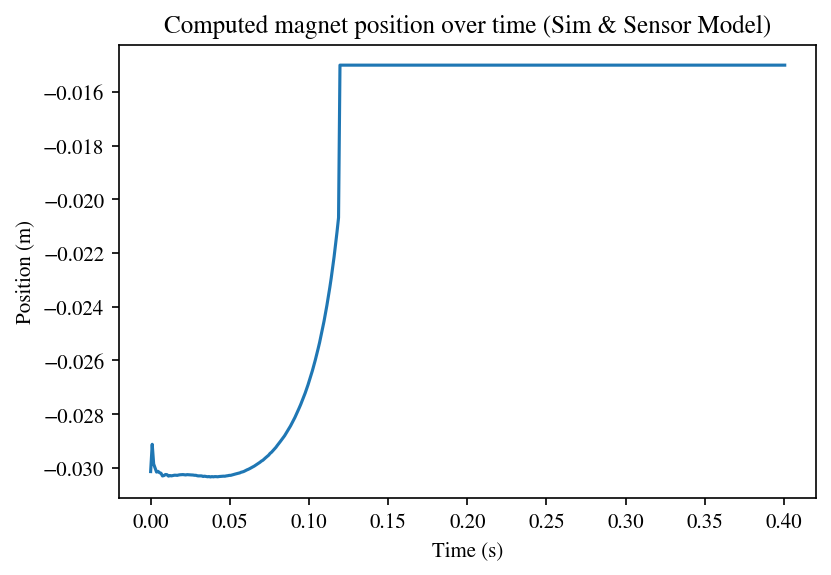

In [294]:
plt.plot(sim.t_list, -np.array(sim.y_list))
plt.title("Computed magnet position over time (Sim & Sensor Model)")
plt.ylabel("Position (m)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

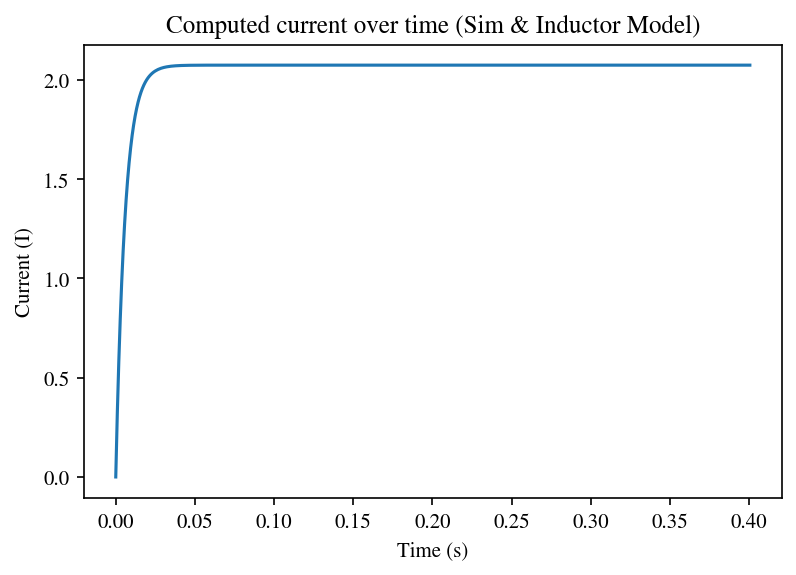

In [295]:
plt.plot(sim.t_list, sim.I_list)
plt.title("Computed current over time (Sim & Inductor Model)")
plt.ylabel("Current (I)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

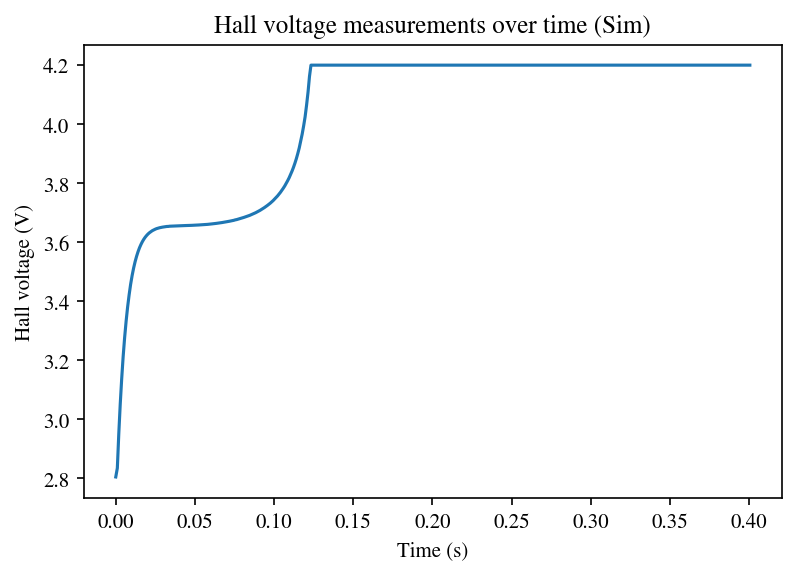

In [296]:
plt.plot(sim.t_list, sim.V_h_list)
plt.title("Hall voltage measurements over time (Sim)")
plt.ylabel("Hall voltage (V)")
plt.xlabel("Time (s)")

In [297]:
# # Let's see how our model compares
# model = MagLevModel()
# model.testPosition(end_t = 0.4, test_V_e = 5)

# plt.plot(model.ts, -np.array(model.ys[1:]), label='Model Only')
# plt.plot(sim.t_list, -np.array(sim.y_list), '.-', label='Sim & Position/Inductor Model')
# plt.title("Position Over Time Comparison (V_e = 5)")
# plt.ylabel("Position (m)")
# plt.xlabel("Time (s)")
# plt.legend()

Starting system...
System started
System stopped


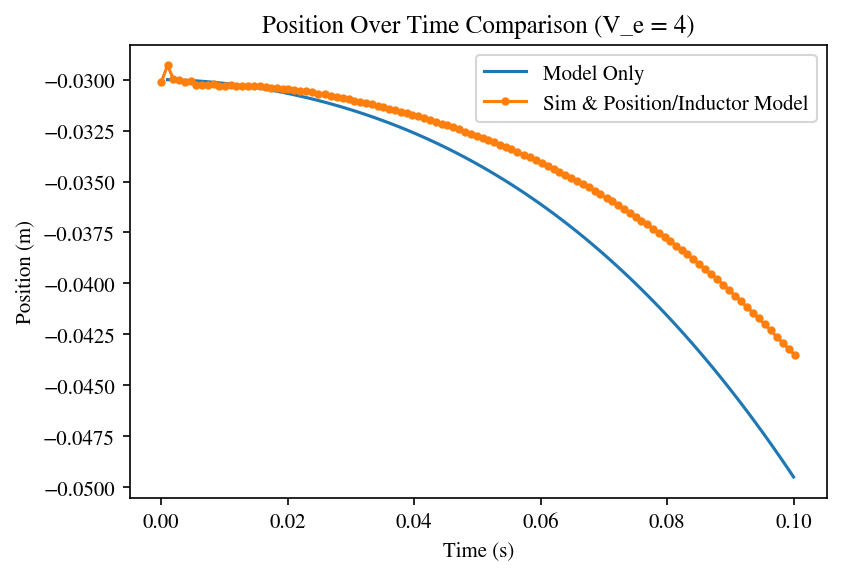

In [298]:
test_V_e = 4

sim.runModelTest(0.1, test_V_e) # Run simulator for 0.4 seconds and at V_e = 5
model = MagLevModel()
model.testPosition(end_t = 0.1, test_V_e = test_V_e)

plt.plot(model.ts, -np.array(model.ys[1:]), label='Model Only')
plt.plot(sim.t_list, -np.array(sim.y_list), '.-', label='Sim & Position/Inductor Model')
plt.title("Position Over Time Comparison (V_e = 4)")
plt.ylabel("Position (m)")
plt.xlabel("Time (s)")
plt.legend()

## Test Plots 2 (Simulation validation with $V_e = 0$)
These graphs depict dropping an unweighted magnet with the amplifer off just as an added layer of model validation.

In [299]:
sim = MagLevController()
sim.runModelTest(0.4, 0) # Run simulator for 0.4 seconds and at V_e = 0

Starting system...
System started
System stopped


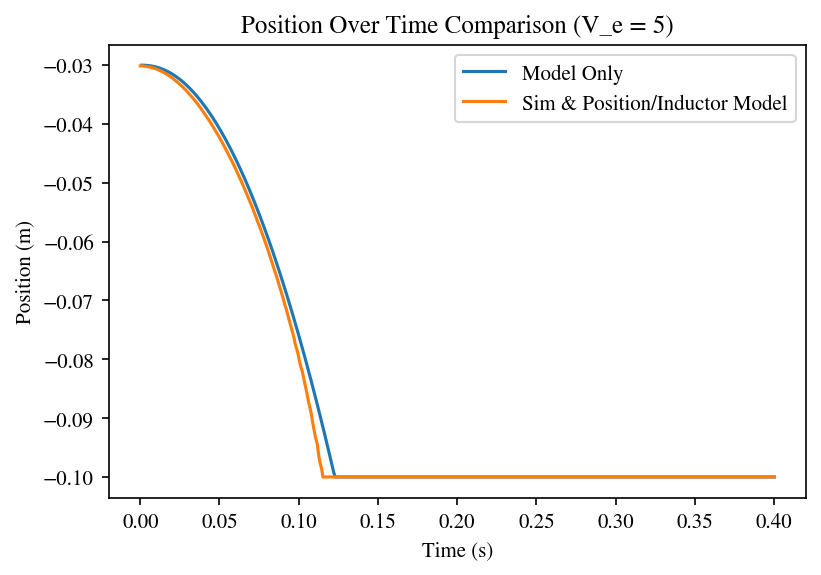

In [300]:
# Let's see how our model compares
model = MagLevModel()
model.testPosition(end_t = 0.4, test_V_e = 0)

plt.plot(model.ts, -np.array(model.ys[1:]), label='Model Only')
plt.plot(sim.t_list, -np.array(sim.y_list), label='Sim & Position/Inductor Model')
plt.title("Position Over Time Comparison (V_e = 5)")
plt.ylabel("Position (m)")
plt.xlabel("Time (s)")
plt.legend()

## Test Plots 3 (PID controller testing)

In [301]:
sim = MagLevController()
model = MagLevModel()

In [308]:
end_t=0.3
# Kp=5000
# Ki=10000
# Kd=0
k = 1
Kp = k*1700
Ki = k*0
Kd = k*0

# Kp = k*180
# Ki = k*1600
# Kd = k*100

# Whether to start magnet off at setpoint or not
warmup = True

sim.runPIDControllerTest(end_t, Kp, Ki, Kd, warmup)
model.runPIDControllerTest(end_t, Kp, Ki, Kd, warmup)

Starting system...
System started
System stopped


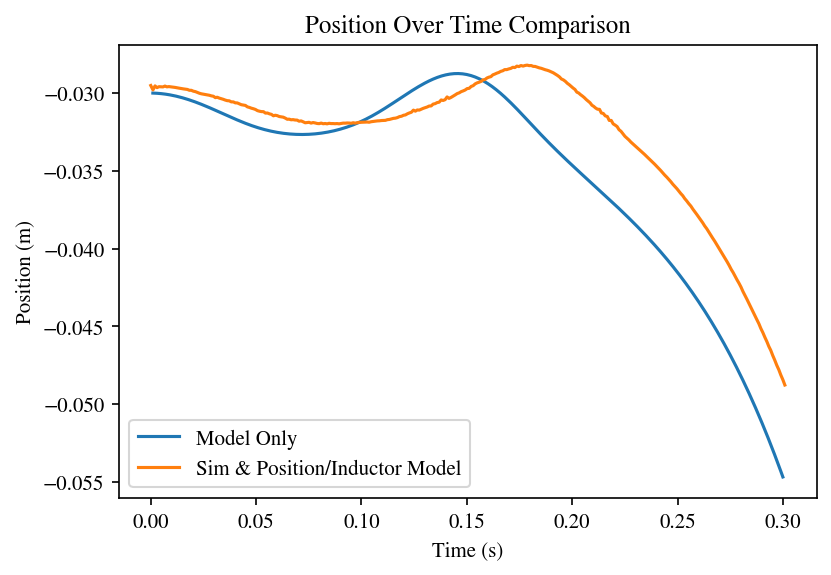

In [309]:
plt.plot(model.ts, -np.array(model.ys[1:]), label='Model Only')
plt.plot(sim.t_list, -np.array(sim.y_list), '-', label='Sim & Position/Inductor Model')
plt.title("Position Over Time Comparison")
plt.ylabel("Position (m)")
plt.xlabel("Time (s)")
plt.legend()

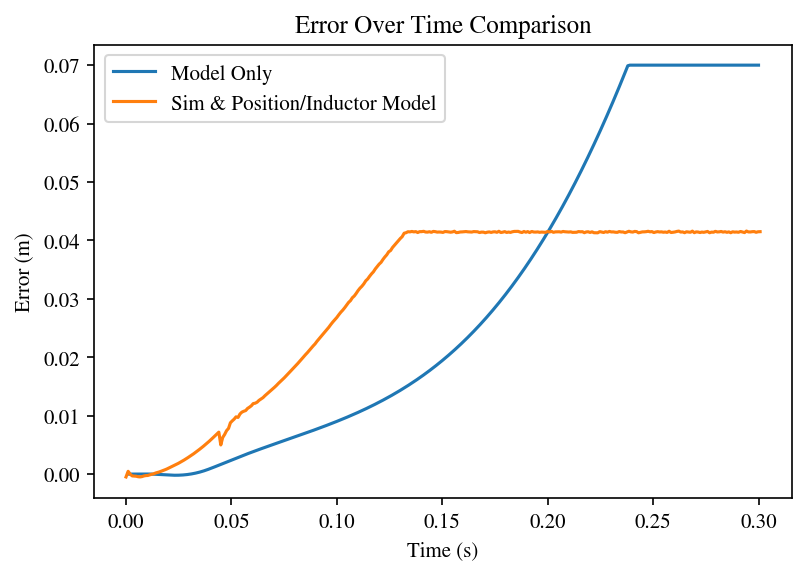

In [304]:
plt.plot(model.ts, np.array(model.e_list), '-', label='Model Only')
plt.plot(sim.t_list, np.array(sim.e_list), '-', label='Sim & Position/Inductor Model')
plt.title("Error Over Time Comparison")
plt.ylabel("Error (m)")
plt.xlabel("Time (s)")
plt.legend()

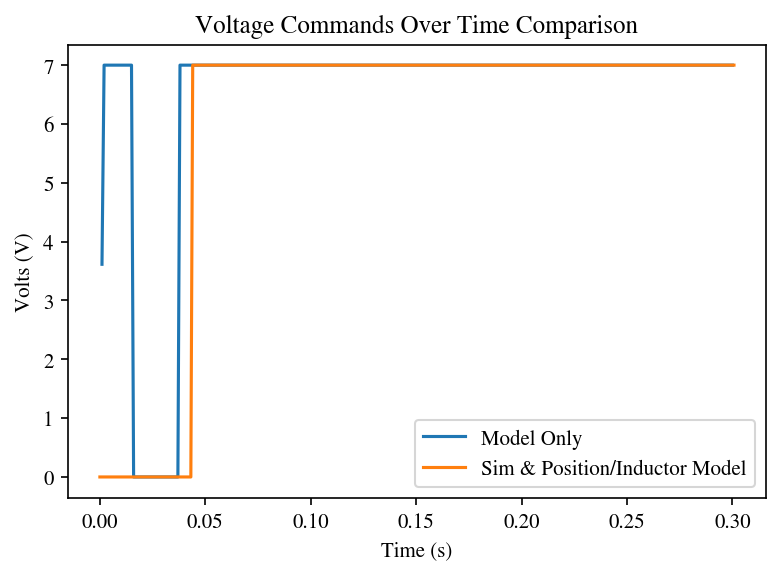

In [305]:
plt.plot(model.ts, np.array(model.V_e_list), '-', label='Model Only')
plt.plot(sim.t_list, np.array(sim.V_e_list), '-', label='Sim & Position/Inductor Model')
plt.title("Voltage Commands Over Time Comparison")
plt.ylabel("Volts (V)")
plt.xlabel("Time (s)")
plt.legend()

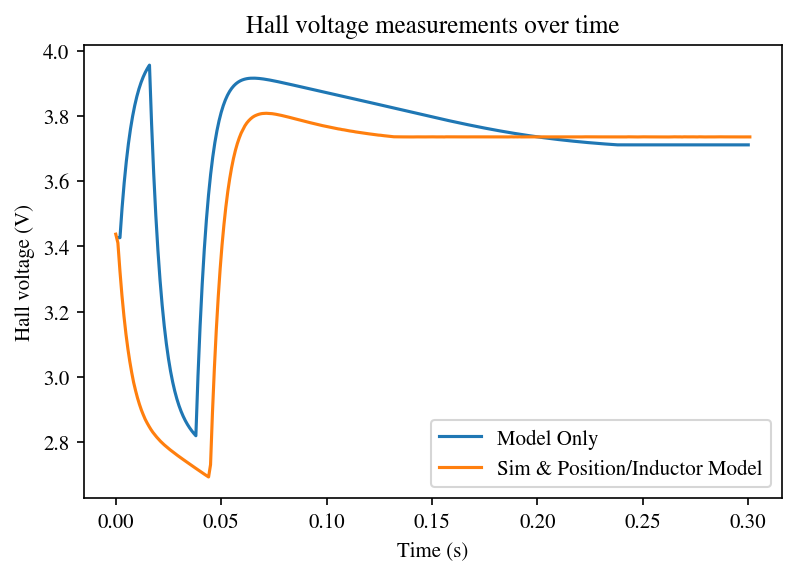

In [306]:
plt.plot(model.ts, model.V_hs, label='Model Only')
plt.plot(sim.t_list, sim.V_h_list, label='Sim & Position/Inductor Model')
plt.title("Hall voltage measurements over time")
plt.ylabel("Hall voltage (V)")
plt.xlabel("Time (s)")
plt.legend()

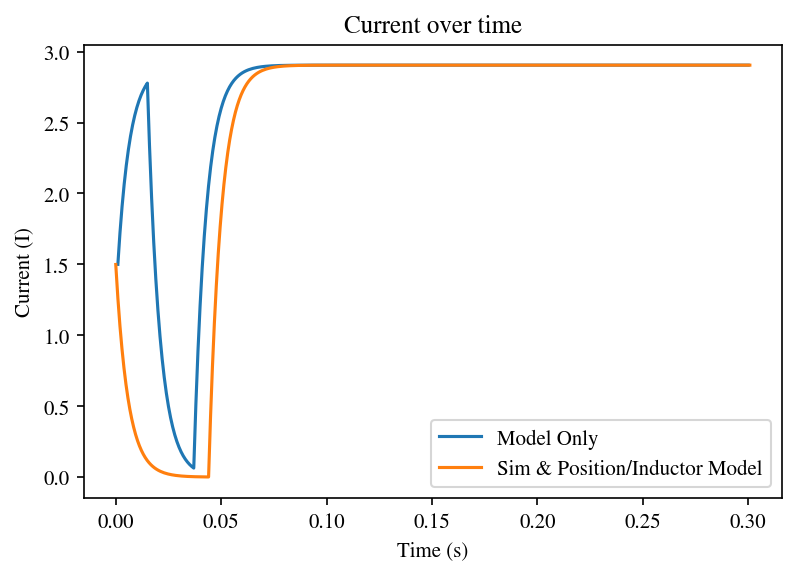

In [307]:
plt.plot(model.ts, model.Is, label='Model Only')
plt.plot(sim.t_list, sim.I_list, label='Sim & Position/Inductor Model')
plt.title("Current over time")
plt.ylabel("Current (I)")
plt.xlabel("Time (s)")
plt.legend()

# Conclusions
- dip is caused when magnet is dropped but the electromagnet is not turned on until a little later (it falls as the magnet is "warming up")
- the little bit of noise at the beginning can be tuned out with increasing the inductance - however, don't make the inductance too big or the dynamics become incorrect
- if you turn on the electromagnet before dropping the magnet, be sure to change current accordingly
- we should add more error checking for clipping - the position measurements right now are faulty at steady-state because we're not accounting for the fact that the clipping is happening - this drove me nuts with debugging
- equally balancing gravity (as close as possible) with default mass happens at PWM 85, which translates to a voltage of approximately 3.77778
- might need to add a cap on position measurements - the magnet physically can't move as fast as it thinks

In [25]:
# Computing linearization point (find mass to use given a current and position setpoint)
# TODO: compute ideal value of I_bar that perfectly offsets y_bar

(-C1 * I_bar) / (9.81 * L * 2 * math.pi * y_bar**2) # mass necessary for linearization point

0.00602185483984644

In [27]:
a2 = (-C1 * I_bar) / (m * L * 2 * math.pi * y_bar**3)
math.sqrt(a2) # pole locations of second plant

25.61995662649065

In [ ]:
- R / L # pole locations of first plant